In [8]:
import h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
import preprocessing


In [2]:
dataPath = '/home/WindowsDrive/Shared/Top_Tagging_Data/test.h5'
# trainDictFile = open('trainDict.pkl', 'w')
# testDictFile = open('testDict.pkl', 'w')
# tagger_type = 'pfn'

## Putting the data into an array, as well as making the arrays of labels and weights, then saving them to file so we don't need to leave them in memory the whole time

## DON'T RUN THIS AGAIN UNLESS YOU HAVE TO

In [3]:
"""

with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])
    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy', npDataLabels)
    del(npDataLabels)

    npDataWeights = np.array(data['weights'])
    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy', npDataWeights)
    del(npDataWeights)

    
    constitDataArr = []

    for key in data.attrs.get('constit'):
        constitDataArr.append(data[key][...])

    npConstitDataArr = np.array(constitDataArr)
    del(constitDataArr)

    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy', npConstitDataArr)
    del(npConstitDataArr)

    jetDataArr = []

    for key in ['fjet_eta', 'fjet_m', 'fjet_phi', 'fjet_pt']:
        jetDataArr.append(data[key][...])
    
    npJetDataArr = np.array(jetDataArr)
    del(jetDataArr)

    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npJetDataArr.npy', npJetDataArr)
    del(npJetDataArr)

"""


"\n\nwith h5py.File(dataPath, 'r') as data:\n\n    npDataLabels = np.array(data['labels'])\n    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy', npDataLabels)\n    del(npDataLabels)\n\n    npDataWeights = np.array(data['weights'])\n    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy', npDataWeights)\n    del(npDataWeights)\n\n    \n    constitDataArr = []\n\n    for key in data.attrs.get('constit'):\n        constitDataArr.append(data[key][...])\n\n    npConstitDataArr = np.array(constitDataArr)\n    del(constitDataArr)\n\n    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy', npConstitDataArr)\n    del(npConstitDataArr)\n\n    jetDataArr = []\n\n    for key in ['fjet_eta', 'fjet_m', 'fjet_phi', 'fjet_pt']:\n        jetDataArr.append(data[key][...])\n    \n    npJetDataArr = np.array(jetDataArr)\n    del(jetDataArr)\n\n    np.save('/home/WindowsDrive/Shared/Top_Tagging_Data/npJetDataArr.npy', npJetDataArr)\n    del(npJ

## Here we import the data again and split it up into test and train

In [4]:
"""constitDataArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy')
labelsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy')
weightsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy')

pt_train, pt_test, eta_train, eta_test, phi_train, phi_test, E_train, E_test, labels_train, labels_test, weights_train, weights_test = train_test_split(constitDataArr[0], constitDataArr[1], constitDataArr[2], constitDataArr[3], labelsArr, weightsArr, test_size=0.33, random_state=69, shuffle=True)

del(constitDataArr)
del(labelsArr)
del(weightsArr)"""


"constitDataArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy')\nlabelsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy')\nweightsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy')\n\npt_train, pt_test, eta_train, eta_test, phi_train, phi_test, E_train, E_test, labels_train, labels_test, weights_train, weights_test = train_test_split(constitDataArr[0], constitDataArr[1], constitDataArr[2], constitDataArr[3], labelsArr, weightsArr, test_size=0.33, random_state=69, shuffle=True)\n\ndel(constitDataArr)\ndel(labelsArr)\ndel(weightsArr)"

## Trying high level now instead of constituent because fuck that much data

In [11]:
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])

    npDataWeights = np.array(data['weights'])
    
    hlDataArr = {key: data[key][...] for key in data.attrs.get('hl')}


## Preprocessing

In [12]:
processed_dict = preprocessing.high_level(hlDataArr)
processed_df = pd.DataFrame(hlDataArr)


In [13]:
data_train, data_test, labels_train, labels_test, weights_train, weights_test = train_test_split(processed_df, npDataLabels, npDataWeights, test_size=0.33, random_state=69, shuffle=True)

In [11]:
df_train = pd.DataFrame()
df_train["label"] = labels_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

print(sigSumWeights)

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

print(modsigSumWeights)


final_weights_train = df_train["weights"]

831597.0
833473.1


In [14]:
model = Sequential()
model.add(keras.Input(shape=15))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   
model.fit(data_train, labels_train, sample_weight=weights_train, epochs=8, batch_size=100, verbose=1)

Epoch 1/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.4096
Epoch 2/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.3762
Epoch 3/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.3720
Epoch 4/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.3695
Epoch 5/8
16644/16644 [==============================] - 51s 3ms/step - loss: 0.3684
Epoch 6/8
16644/16644 [==============================] - 50s 3ms/step - loss: 0.3672
Epoch 7/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.3666
Epoch 8/8
16644/16644 [==============================] - 49s 3ms/step - loss: 0.3658


In [15]:
pred_test = model.predict(data_test)


25618/25618 [==============================] - 43s 2ms/step


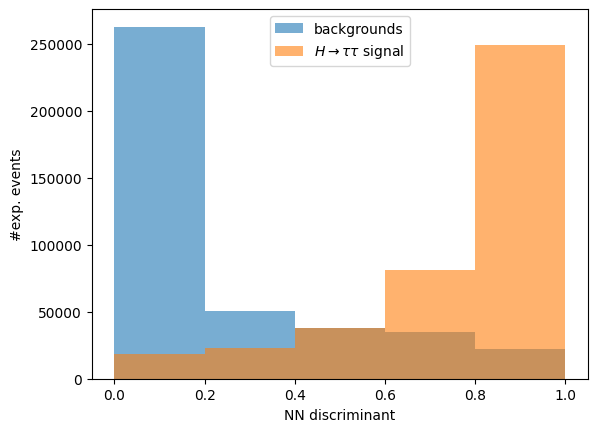

In [19]:
dfNN_test = pd.DataFrame()
dfNN_test["labels"] = labels_test
dfNN_test["predictions"] = pred_test
dfNN_test["weights"] = weights_test

signalVals = dfNN_test[dfNN_test['labels']== 1] 
backgroundVals = dfNN_test[dfNN_test['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

# bkgHistNN = plt.hist(backgroundVals['predictions'], bins=5, label="backgrounds", range=[0,1], alpha=0.6)
# sigHistNN = plt.hist(signalVals['predictions'], bins=5, label="signals", range=[0,1], alpha=0.6)

plt.legend()
# plt.yscale('log')
plt.show()

In [17]:
pred_train = model.predict(data_train)

52012/52012 [==============================] - 86s 2ms/step


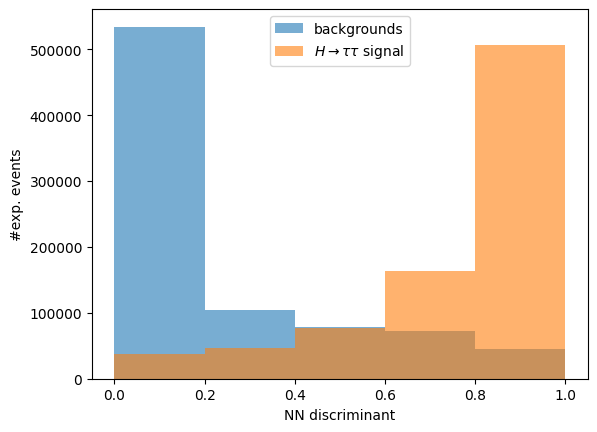

In [18]:
dfNN_train = pd.DataFrame()
dfNN_train["labels"] = labels_train
dfNN_train["predictions"] = pred_train
dfNN_train["weights"] = weights_train

signalVals = dfNN_train[dfNN_train['labels']== 1] 
backgroundVals = dfNN_train[dfNN_train['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

In [20]:
model.save('./models/highLevel_preprocessed_no_weights_processing')

INFO:tensorflow:Assets written to: ./models/highLevel_preprocessed_no_weights_processing/assets
